# STACK OVERFLOW TAG PREDICTION

#### IMPORTING THE REQUIRED DATASETS

In [ ]:


import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

#### USING PANDAS WITH SQLITE3 TO LOAD DATA

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    start=datetime.now()
    disk_engine=create_engine('sqlite:///train.db')
    start=dt.datetime.now()
    chunksize=180000
    j=0
    index_start=1
    for df in pd.read_csv('Train.csv',names=['Id','Title','Body','Tags'],chunksize=chunksize,iterator=True,encoding='utf-8'):
        df.index+=index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data',disk_engine,if_exists='append')
        index_start=df.index[-1]+1
    print('Time taken to run this cell :',datetime.now()-start)

In [3]:
if os.path.isfile('train.db'):
    start=datetime.now()
    con=sqlite3.connect('train.db')
    num_rows=pd.read_sql_query("""SELECT count(*) FROM data""",con)
    print("The number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :",datetime.now()-start)
else:
    print("Please download the train.db file from drive or generate the file by running the above cell")

The number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:04.595229


In [4]:
if os.path.isfile('train.db'):
    start=datetime.now()
    con=sqlite3.connect('train.db')
    df_no_dup=pd.read_sql_query("""SELECT Title,Body,Tags,COUNT(*) as cnt_dup FROM data GROUP BY Title,Body,Tags""",con)
    con.close()
    print("Time taken to run this cell :",datetime.now()-start)
else:
    print("Please download the train.db file from drive or generate the file by running the above cell")    

Time taken to run this cell : 0:05:08.095619


In [5]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [6]:
print("No. of duplicate questions :",num_rows['count(*)'].values[0]-df_no_dup.shape[0],"(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

No. of duplicate questions : 1827881 ( 30.292038906260256 % )


In [7]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

#### REMOVING ROWS WITH NO TAGS

In [8]:
def check(text):
    if text==None:
        return 0
    else:
        return len(text.split(" "))

In [9]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(check)
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:02.081433


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [10]:
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

In [11]:
# removing the rows with no tags
df_no_dup=df_no_dup[df_no_dup['tag_count']!=0]

In [12]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train2',disk_dup)

In [13]:
if os.path.isfile('train_no_dup.db'):
    start=datetime.now()
    con=sqlite3.connect('train_no_dup.db')
    tag_data=pd.read_sql_query("""SELECT Tags FROM no_dup_train2""",con)
    con.close()
    print(tag_data.head())
    print("Time taken to run this cell",datetime.now()-start)

                                  Tags
0                                c++ c
1          c# silverlight data-binding
2  c# silverlight data-binding columns
3                             jsp jstl
4                            java jdbc
Time taken to run this cell 0:00:28.387227


## ANALYSIS OF TAGS

In [14]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [15]:
tags=vectorizer.get_feature_names()
print("Some of the tags we have :",tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [16]:
freqs=tag_dtm.sum(axis=0).A1
result=dict(zip(tags,freqs))

In [17]:
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [18]:
tag_df_sorted=tag_df.sort_values(['Counts'],ascending=False)
tag_counts=tag_df_sorted['Counts'].values

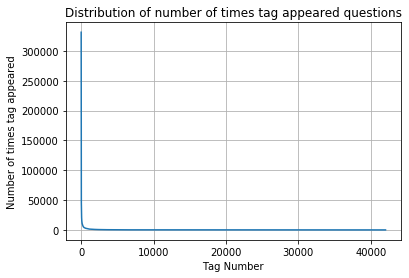

In [19]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag Number")
plt.ylabel("Number of times tag appeared")
plt.show()

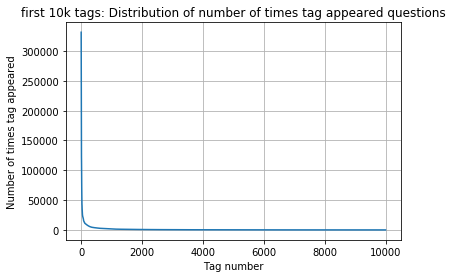

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2986   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [20]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

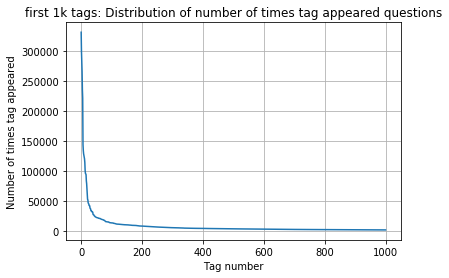

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [21]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

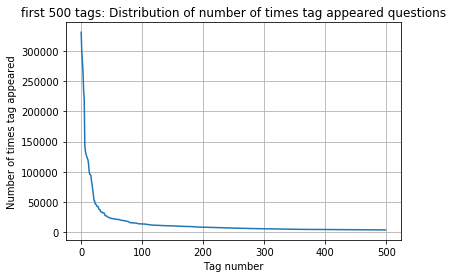

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [22]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

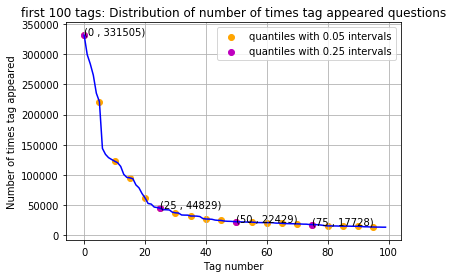

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [23]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [24]:
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this problem.

In [25]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206308 datapoints.
[2, 3, 4, 2, 2]


In [26]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899442


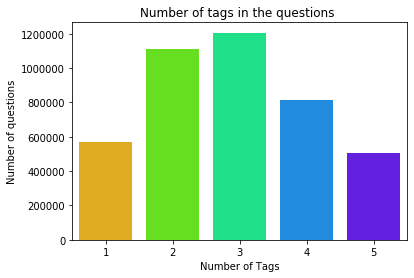

In [27]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<p> Most of the time 2 or 3 tags are occuring.Hence micro averaged F1-score is the best metric for our purpose of multi-label calssification. </p>

## PLOTTING THE WORDCLOUD

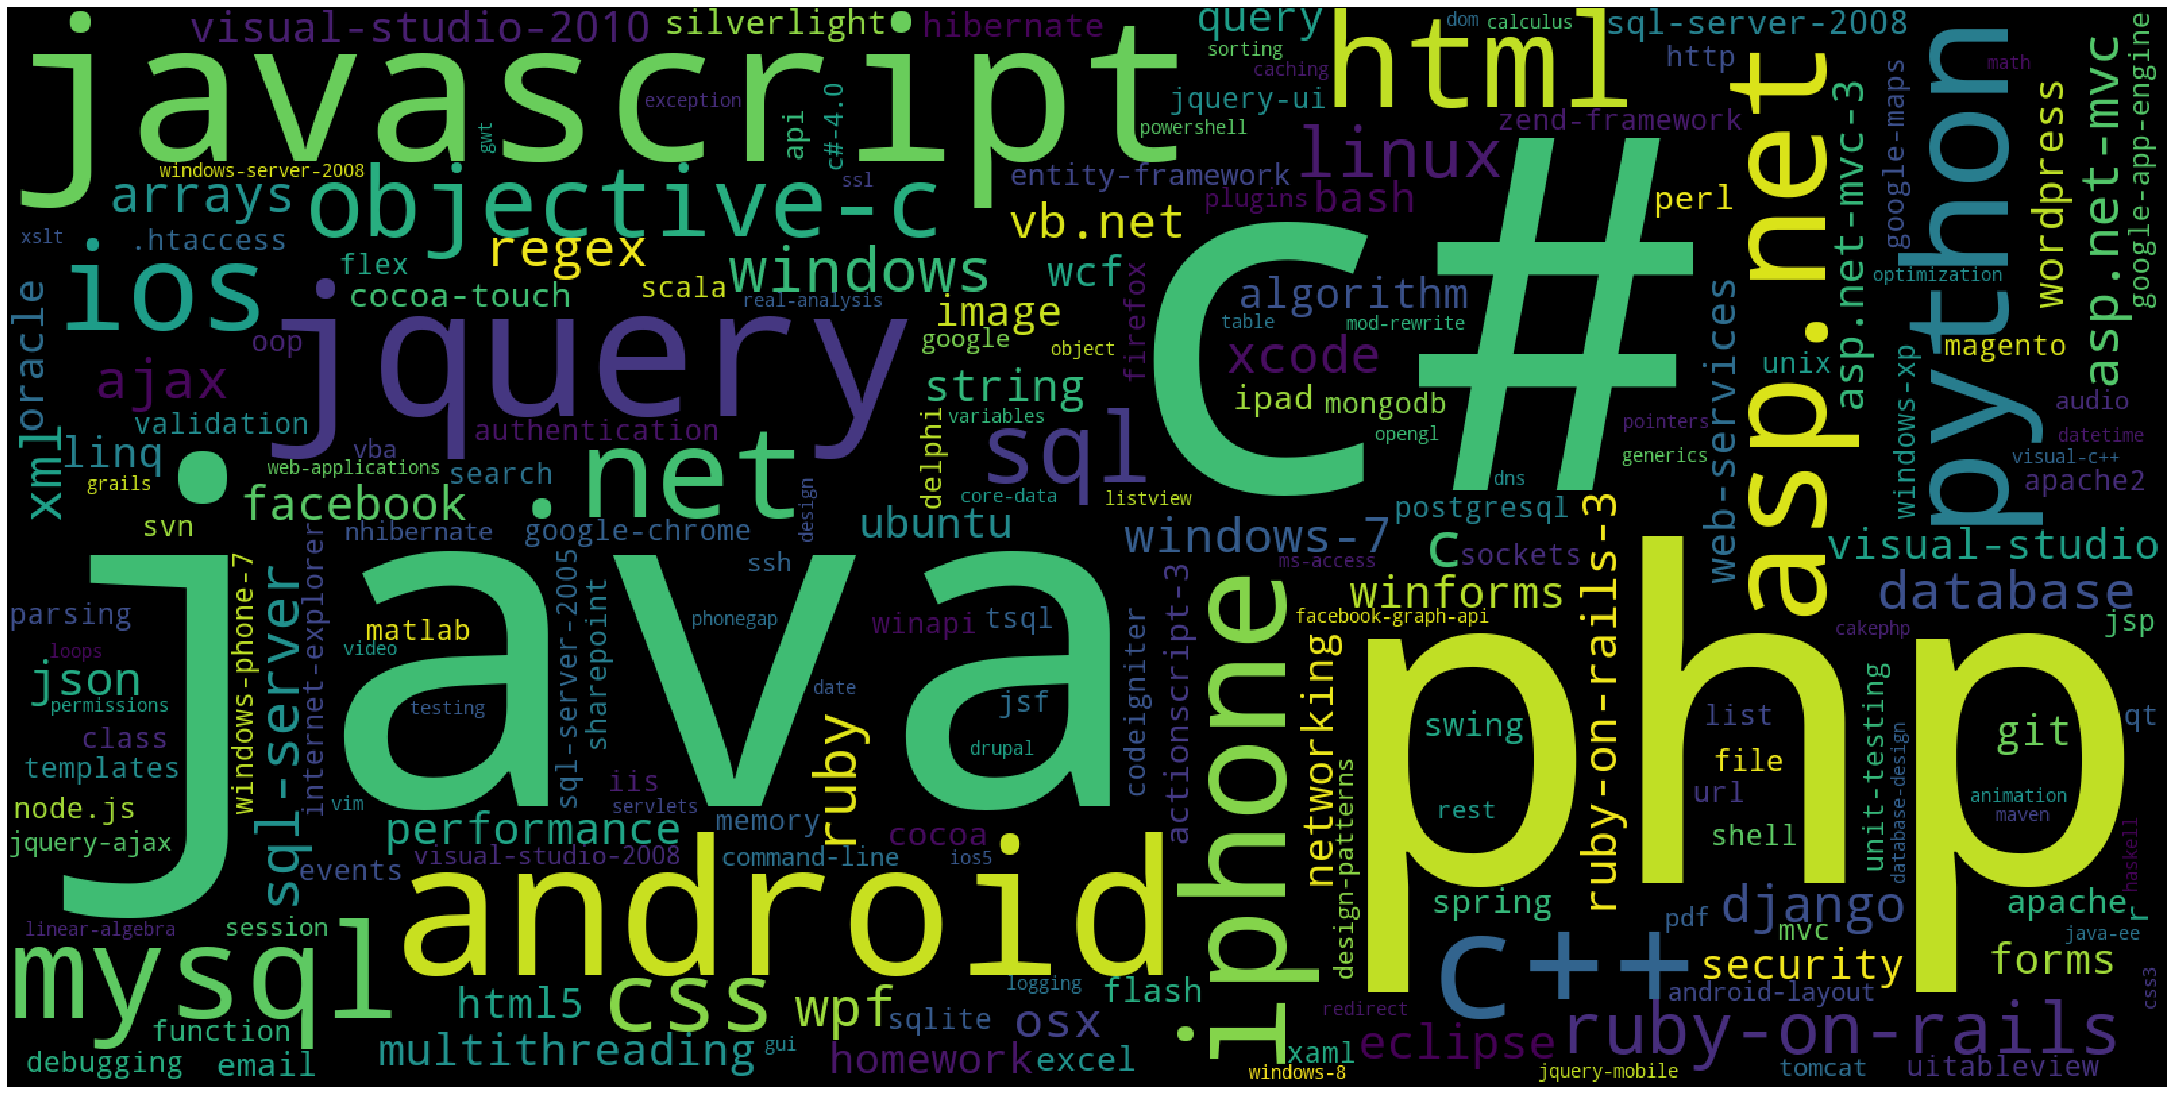

Time taken to run this cell : 0:00:03.041982


In [28]:
start = datetime.now()

tup = dict(result.items())
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

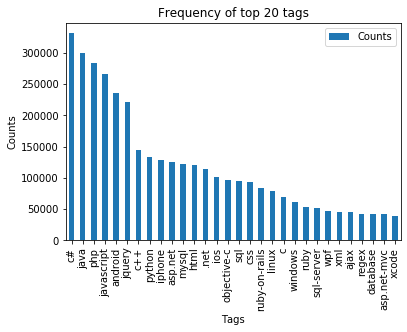

In [29]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
def striphtml(data):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',str(data))
stop_words=set(stopwords.words('english'))
stemmer=SnowballStemmer("english")

In [32]:
def create_connection(db_file):

    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
 
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [33]:
start=datetime.now()
read_db='train_no_dup.db'
write_db='Processed.db'
if os.path.isfile(read_db):
    conn_r=create_connection(read_db)
    if conn_r is not None:
        reader=conn_r.cursor()
        reader.execute("SELECT Title,Body,Tags From no_dup_train2 ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w=create_connection(write_db)
    if conn_w is not None:
        tables=checkTableExists(conn_w)
        writer=conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared all the rows")
print("Time taken to run this cell ",datetime.now()-start)            

Tables in the databse:
QuestionsProcessed
Cleared all the rows
Time taken to run this cell  0:08:26.282206


In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
start=datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_processed=0

for row in reader:
    is_code=0
    
    title,question,tags=row[0],row[1],row[2]
    if '<code>' in question:
        questions_with_code+=1
        is_code+=1
    x=len(question)+len(title)
    len_pre+=x
    
    code=str(re.findall(r'<code>(.*?)</code>',question,flags=re.DOTALL))
    question=re.sub('<code>(.*?)</code>','',question,flags=re.DOTALL|re.MULTILINE)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    question=str(title)+ " "+ str(question)
    question=re.sub(r'[^A-za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup=(question,code,tags,x,len(question),is_code)
    questions_processed+=1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code)values(?,?,?,?,?,?)",tup)
    if(questions_processed%100000==0):
        print("no. of questions completed:",questions_processed)
        
no_dup_avg_len_pre=(len_pre*1.0)/questions_processed
no_dup_avg_len_post=(len_post*1.0)/questions_processed

print("Avg. length of questions(Title+Body) before processing: ",no_dup_avg_len_pre)
print("Avg. length of questions(Title+Body) after processing: ",no_dup_avg_len_post)
print("% of questions containing code: ",(questions_with_code*100.0)/questions_processed)
print("Time taken to run this cell: ",datetime.now()-start)

no. of questions completed: 100000
no. of questions completed: 200000
no. of questions completed: 300000
no. of questions completed: 400000
no. of questions completed: 500000
no. of questions completed: 600000
no. of questions completed: 700000
no. of questions completed: 800000
no. of questions completed: 900000
Avg. length of questions(Title+Body) before processing:  1172.032117032117
Avg. length of questions(Title+Body) after processing:  39.61512561512561
% of questions containing code:  57.65405765405765
Time taken to run this cell:  0:04:22.501973


In [36]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [37]:
if os.path.isfile(write_db):
    conn_r=create_connection(write_db)
    if conn_r is not None:
        reader=conn_r.cursor()
        reader.execute("SELECT question FROM QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print("="*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print("-"*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('applic error none',)
----------------------------------------------------------------------------------------------------
('find reduct formula none',)
----------------------------------------------------------------------------------------------------
('set instanc properti javascript scriptabl member properti silverlight none',)
----------------------------------------------------------------------------------------------------
('zoom len prime len photo comparison none',)
----------------------------------------------------------------------------------------------------
('disabl toggl landscap portrait mobil web app android browser io mobil safari none',)
----------------------------------------------------------------------------------------------------
('issu eregi depric none',)
----------------------------------------------------------------------------------------------------
('safe uninstal reinstal servic pack vista none',)
--------------------

In [38]:
start=datetime.now()
write_db="Processed.db"
if os.path.isfile(write_db):
    conn_r=create_connection(write_db)
    if conn_r is not None:
        preprocessed_data=pd.read_sql_query("""SELECT question,Tags from QuestionsProcessed""",conn_r)
conn_r.commit()
conn_r.close()
print("Time taken ",datetime.now()-start)

Time taken  0:00:01.740344


In [39]:
preprocessed_data.head()

,question,tags
0,php strtotim return wrong result none,php timestamp
1,applic error none,windows visual-c++
2,find reduct formula none,calculus integral
3,set instanc properti javascript scriptabl memb...,javascript silverlight htmlbridge
4,zoom len prime len photo comparison none,lens equipment-recommendation focal-length tel...


In [40]:
print("Number of datapoints in sample:",preprocessed_data.shape[0])
print("Number of dimensions:",preprocessed_data.shape[1])

Number of datapoints in sample: 999999
Number of dimensions: 2


In [41]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [42]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [43]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

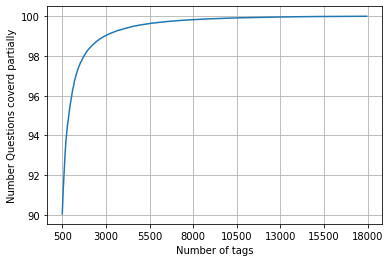

with  5500 tags we are covering  99.033 % of questions


In [44]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [45]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9666 out of  999999


In [46]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35439
number of tags taken : 5500 ( 15.519625271593442 %)


In [47]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [48]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 5500)
Number of data points in test data : (200000, 5500)


In [49]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:26.167079


In [50]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799999, 9762) Y : (799999, 5500)
Dimensions of test data X: (200000, 9762) Y: (200000, 5500)


In [51]:
classifier=OneVsRestClassifier(SGDClassifier(loss='log',alpha=0.00001,penalty='l1'),n_jobs=1)
classifier.fit(x_train_multilabel,y_train)
predictions=classifier.predict(x_test_multilabel)

print("Accuracy: ",metrics.accuracy_score(y_test,predictions))
print("Macro f1 score: ",metrics.f1_score(y_test,predictions,average='macro'))
print("Micro f1 score: ",metrics.f1_score(y_test,predictions,average='micro'))
print("Hamming loss: ",metrics.hamming_loss(y_test,predictions))
print("Precision call report: \n",metrics.classification_report(y_test,predictions))

Accuracy:  0.08524
Macro f1 score:  0.11096741026727523
Micro f1 score:  0.3677904292012668
Hamming loss:  0.00040724181818181817
Precision call report: 
               precision    recall  f1-score   support

           0       0.62      0.18      0.28     16056
           1       0.83      0.39      0.53     14191
           2       0.88      0.46      0.61     13633
           3       0.80      0.36      0.49     12723
           4       0.94      0.65      0.77     11249
           5       0.88      0.56      0.69     10535
           6       0.69      0.24      0.35      6736
           7       0.90      0.56      0.69      6312
           8       0.74      0.35      0.48      6218
           9       0.83      0.35      0.49      6060
          10       0.89      0.54      0.67      5760
          11       0.55      0.14      0.23      5698
          12       0.60      0.10      0.17      5432
          13       0.63      0.25      0.36      4838
          14       0.63      0.18 

In [52]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl') 

C:\Users\Krishna\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['lr_with_equal_weight.pkl']

In [53]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [55]:
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train2 LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [59]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+str(question)
    


    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 113
Percent of questions containing code: 57
Time taken to run this cell : 0:03:41.386778


In [60]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [61]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('countabl subaddit lebesgu measur countabl subaddit lebesgu measur countabl subaddit lebesgu measur none',)
----------------------------------------------------------------------------------------------------
('hql equival sql queri hql equival sql queri hql equival sql queri none',)
----------------------------------------------------------------------------------------------------
('undefin symbol architectur i386 objc class skpsmtpmessag referenc error undefin symbol architectur i386 objc class skpsmtpmessag referenc error undefin symbol architectur i386 objc class skpsmtpmessag referenc error none',)
----------------------------------------------------------------------------------------------------
('java.lang.nosuchmethoderror javax.servlet.servletcontext.geteffectivesessiontrackingmod ljava util set java.lang.nosuchmethoderror javax.servlet.servletcontext.geteffectivesessiontrackingmod ljava util set java.lang.nosuchmethoderror javax.servlet.servlet

In [62]:
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [63]:
preprocessed_data.head()

,question,tags
0,sql inject issu prevent correct form submiss p...,php forms
1,countabl subaddit lebesgu measur countabl suba...,real-analysis measure-theory
2,hql equival sql queri hql equival sql queri hq...,hibernate hql
3,undefin symbol architectur i386 objc class skp...,iphone email-integration
4,java.lang.nosuchmethoderror javax.servlet.serv...,java servlets jboss


In [64]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 499994
number of dimensions : 2


In [66]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [67]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

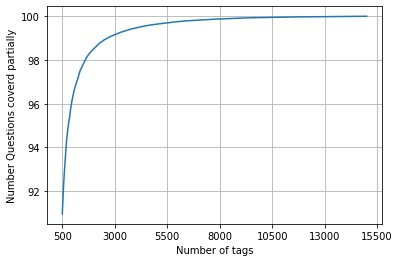

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [68]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [69]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  499994


In [70]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [71]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (99994, 500)


In [72]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:21.186564


In [73]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 11445) Y : (400000, 500)
Dimensions of test data X: (99994, 11445) Y: (99994, 500)


In [74]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2212132727963678
Hamming loss  0.0028909734584075045
Micro-average quality numbers
Precision: 0.7231, Recall: 0.2728, F1-measure: 0.3962
Macro-average quality numbers
Precision: 0.5279, Recall: 0.2180, F1-measure: 0.2914
              precision    recall  f1-score   support

           0       0.94      0.52      0.67      5518
           1       0.69      0.19      0.30      8189
           2       0.83      0.31      0.45      6529
           3       0.83      0.34      0.49      3229
           4       0.81      0.35      0.49      6430
           5       0.82      0.29      0.42      2878
           6       0.89      0.41      0.56      5086
           7       0.88      0.46      0.61      4533
           8       0.61      0.10      0.18      2999
           9       0.78      0.41      0.54      2765
          10       0.58      0.14      0.22      3051
          11       0.71      0.29      0.41      3009
          12       0.66      0.21      0.31      2630
         

In [75]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

['lr_with_more_title_weight.pkl']

In [76]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.22673360401624099
Hamming loss  0.0028668320099205953
Micro-average quality numbers
Precision: 0.7099, Recall: 0.2965, F1-measure: 0.4183
Macro-average quality numbers
Precision: 0.5336, Recall: 0.2418, F1-measure: 0.3171
              precision    recall  f1-score   support

           0       0.92      0.59      0.72      5518
           1       0.68      0.22      0.33      8189
           2       0.81      0.33      0.47      6529
           3       0.82      0.38      0.52      3229
           4       0.79      0.36      0.49      6430
           5       0.80      0.31      0.45      2878
           6       0.88      0.42      0.57      5086
           7       0.86      0.48      0.62      4533
           8       0.63      0.11      0.19      2999
           9       0.78      0.45      0.57      2765
          10       0.59      0.16      0.26      3051
          11       0.68      0.32      0.43      3009
          12       0.61      0.24      0.34      2630
        

In [78]:
joblib.dump(classifier_2, 'lr_with_more_title_weight_logistic.pkl') 

['lr_with_more_title_weight_logistic.pkl']